# 🚀 Forex Momentum Trading System

Sistema di trading quantitativo basato su momentum per 22 coppie valutarie forex.

**Strategia:**
- Ribilanciamento settimanale ogni venerdì
- Top 5 coppie con momentum positivo → Long (20% each)
- Top 5 coppie con momentum negativo → Short (20% each)
- Equal weight allocation
- Prevenzione lookahead bias

---

## 📦 Setup e Importazioni

In [1]:
# Importazioni
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Aggiungi percorso moduli
sys.path.append('../core')

# Importa moduli core - AGGIORNATO per includere commodities
from data_loader import load_forex_and_commodities_data, get_asset_names, validate_data_quality
from signal_generator import generate_momentum_signals, validate_signals
from backtest_engine import BacktestEngine

# Configurazione matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✅ Setup completato con successo!")

✅ Setup completato con successo!


## 📊 Caricamento Dati Forex

In [2]:
# Carica dati forex + commodities
print("🔄 Caricamento dati forex + commodities...")
data = load_forex_and_commodities_data('../data/forex_synchronized_data.parquet', include_commodities=True)

# Ottieni lista asset separati per tipo
asset_names = get_asset_names(data)
print(f"\n📈 Asset disponibili:")
print(f"   • Forex pairs ({len(asset_names['forex'])}): {', '.join(asset_names['forex'][:5])}...")
print(f"   • Commodities ({len(asset_names['commodities'])}): {', '.join(asset_names['commodities'])}")
print(f"   • TOTALE: {len(asset_names['all'])} strumenti")

# Report qualità dati
quality_report = validate_data_quality(data)
print(f"\n📋 Report Qualità Dati:")
print(f"   • Periodo: {quality_report['date_range']['start'].date()} - {quality_report['date_range']['end'].date()}")
print(f"   • Giorni trading: {quality_report['total_rows']:,}")
print(f"   • Valori mancanti: {quality_report['missing_values']}")
print(f"   • Forex pairs: {quality_report['forex_pairs']}")
print(f"   • Commodities: {quality_report['commodities']}")
print(f"   • Totale asset: {quality_report['total_assets']}")

🔄 Caricamento dati forex + commodities...
✓ Loaded forex data: 4066 days, 88 columns
✓ Date range: 2010-01-01 to 2025-08-01
✓ Generated commodity data: 5692 days, 4 commodities
✓ Commodities: GOLD, SILVER, NATGAS, CRUDE
✓ Combined data: 4066 days, 104 columns
✓ Total instruments: 22 forex + 4 commodities

📈 Asset disponibili:
   • Forex pairs (22): AUDCAD, AUDCHF, AUDJPY, AUDNZD, AUDUSD...
   • Commodities (4): CRUDE, GOLD, NATGAS, SILVER
   • TOTALE: 26 strumenti

📋 Report Qualità Dati:
   • Periodo: 2010-01-01 - 2025-08-01
   • Giorni trading: 4,066
   • Valori mancanti: 0
   • Forex pairs: 22
   • Commodities: 4
   • Totale asset: 26


## ⚙️ Selezione Lookback Period

In [3]:
# PUOI MODIFICARE QUI IL LOOKBACK PERIOD PER TESTARE DIVERSI VALORI
lookback_days = 5  # Modifica questo valore per testare: 5, 14, 30, 60, 90, 120, 180

print(f"📅 Lookback period selezionato: {lookback_days} giorni")
print(f"✅ Configurazione completata")

📅 Lookback period selezionato: 5 giorni
✅ Configurazione completata


## 📡 Caricamento Segnali Trading

In [4]:
# Genera segnali momentum dinamicamente con forex + commodities
print(f"🔄 Generazione segnali momentum con lookback {lookback_days} giorni...")
print(f"📊 Analizzando {len(asset_names['all'])} strumenti: {len(asset_names['forex'])} forex + {len(asset_names['commodities'])} commodities")

signals = generate_momentum_signals(
    price_data=data,
    lookback_days=lookback_days,
    top_n=5,  # Top 5 long + top 5 short (su tutti gli asset)
    rebalance_freq='weekly'
)

# Validazione segnali
signal_report = validate_signals(signals)
print(f"\n📊 Report Segnali Trading:")
print(f"   • Posizioni Long: {signal_report['long_positions']:,} (20% each)")
print(f"   • Posizioni Short: {signal_report['short_positions']:,} (20% each)")
print(f"   • Posizioni Neutral: {signal_report['neutral_positions']:,} (0%)")
print(f"   • Total exposure: 200% (100% long + 100% short)")

# Statistiche posizioni giornaliere
daily_long = (signals == 0.2).sum(axis=1)
daily_short = (signals == -0.2).sum(axis=1)

print(f"\n📈 Statistiche Posizioni Giornaliere:")
print(f"   • Media posizioni long: {daily_long.mean():.1f}")
print(f"   • Media posizioni short: {daily_short.mean():.1f}")
print(f"   • Max posizioni long: {daily_long.max()}")
print(f"   • Max posizioni short: {daily_short.max()}")

# Analisi composizione portfolio (forex vs commodities)
forex_cols = [f"{pair}_weight" for pair in asset_names['forex']]
commodity_cols = [f"{comm}_weight" for comm in asset_names['commodities']]

forex_exposure = signals[forex_cols].abs().sum(axis=1).mean()
commodity_exposure = signals[commodity_cols].abs().sum(axis=1).mean() if commodity_cols else 0

print(f"\n🔄 Composizione Portfolio Media:")
print(f"   • Esposizione Forex: {forex_exposure:.2f}")
print(f"   • Esposizione Commodities: {commodity_exposure:.2f}")
print(f"   • Rapporto Commodity/Forex: {commodity_exposure/forex_exposure*100:.1f}%" if forex_exposure > 0 else "   • Solo Forex")

🔄 Generazione segnali momentum con lookback 5 giorni...
📊 Analizzando 26 strumenti: 22 forex + 4 commodities
✓ Generated momentum signals: 5d lookback, 5 long + 5 short
✓ Rebalancing: weekly
✓ Signal range: 2010-01-01 to 2025-08-01

📊 Report Segnali Trading:
   • Posizioni Long: 16,260 (20% each)
   • Posizioni Short: 16,260 (20% each)
   • Posizioni Neutral: 73,196 (0%)
   • Total exposure: 200% (100% long + 100% short)

📈 Statistiche Posizioni Giornaliere:
   • Media posizioni long: 4.0
   • Media posizioni short: 4.0
   • Max posizioni long: 5
   • Max posizioni short: 5

🔄 Composizione Portfolio Media:
   • Esposizione Forex: 1.10
   • Esposizione Commodities: 0.50
   • Rapporto Commodity/Forex: 46.0%


## 🚀 Esecuzione Backtesting

In [5]:
# Inizializza backtesting engine (senza costi di transazione)
print(f"🔄 Inizializzazione Backtesting Engine...")
engine = BacktestEngine(
    initial_capital=100000.0,  # $100,000 capitale iniziale
    leverage=1.0,              # No leverage
    rebalance_frequency='weekly'  # Ribilanciamento settimanale
)

# Esegui backtest
print(f"\n⚡ Esecuzione backtest per strategia {lookback_days}-day momentum...")
start_time = datetime.now()

results = engine.run_backtest(
    price_data=data,
    signals_data=signals,
    verbose=True
)

end_time = datetime.now()
execution_time = (end_time - start_time).total_seconds()

print(f"\n✅ Backtest completato in {execution_time:.2f} secondi")
print(f"   • Giorni processati: {len(engine.portfolio_returns):,}")
print(f"   • Velocità: {len(engine.portfolio_returns)/execution_time:.0f} giorni/secondo")

INFO:backtest_engine:BacktestEngine initialized with 100,000 starting capital
INFO:backtest_engine:Starting backtesting simulation...
INFO:backtest_engine:Detected 26 currency pairs
INFO:backtest_engine:Price data range: 2010-01-01 00:00:00 to 2025-08-01 00:00:00
INFO:backtest_engine:Signals data range: 2010-01-01 00:00:00 to 2025-08-01 00:00:00
INFO:backtest_engine:Calculating daily returns...
INFO:backtest_engine:Calculated returns for 26 pairs
INFO:backtest_engine:Running simulation on 4065 trading days


🔄 Inizializzazione Backtesting Engine...

⚡ Esecuzione backtest per strategia 5-day momentum...


INFO:backtest_engine:Calculating performance metrics...
INFO:backtest_engine:Backtesting completed in 2.95 seconds



BACKTEST PERFORMANCE SUMMARY
Total Return (%)         :     868.25
Annualized Return (%)    :      15.11
Annualized Volatility (%):      15.08
Sharpe Ratio             :       0.87
Maximum Drawdown (%)     :      37.26
Win Rate (%)             :      52.92
Number of Trades         :        812

✅ Backtest completato in 2.95 secondi
   • Giorni processati: 4,065
   • Velocità: 1378 giorni/secondo


## 📈 Risultati Performance

In [13]:
# Estrai metriche chiave
metrics = engine.performance_metrics

print("="*60)
print(f"📊 PERFORMANCE SUMMARY - {lookback_days} DAY MOMENTUM STRATEGY")
print("="*60)

print(f"\n💰 RENDIMENTI:")
print(f"   • Total Return:           {metrics['Total Return (%)']:.2f}%")
print(f"   • Annualized Return:      {metrics['Annualized Return (%)']:.2f}%")
print(f"   • Capitale Iniziale:      ${metrics['Starting Value']:,.0f}")
print(f"   • Capitale Finale:        ${metrics['Ending Value']:,.0f}")

print(f"\n⚡ RISCHIO:")
print(f"   • Volatilità Annualizzata: {metrics['Annualized Volatility (%)']:.2f}%")
print(f"   • Sharpe Ratio:           {metrics['Sharpe Ratio']:.3f}")
print(f"   • Maximum Drawdown:       {metrics['Maximum Drawdown (%)']:.2f}%")
print(f"   • Sortino Ratio:          {metrics['Sortino Ratio']:.3f}")

print(f"\n📊 TRADING:")
print(f"   • Win Rate:               {metrics['Win Rate (%)']:.2f}%")
print(f"   • Profit Factor:          {metrics['Profit Factor']:.3f}")
print(f"   • Giorni Trading:         {metrics['Trading Days']:,}")

print("\n" + "="*60)

📊 PERFORMANCE SUMMARY - 5 DAY MOMENTUM STRATEGY

💰 RENDIMENTI:
   • Total Return:           868.25%
   • Annualized Return:      15.11%
   • Capitale Iniziale:      $100,000
   • Capitale Finale:        $968,252

⚡ RISCHIO:
   • Volatilità Annualizzata: 15.08%
   • Sharpe Ratio:           0.869
   • Maximum Drawdown:       37.26%
   • Sortino Ratio:          1.359

📊 TRADING:
   • Win Rate:               52.92%
   • Profit Factor:          1.182
   • Giorni Trading:         4,065



## 📊 Visualizzazioni

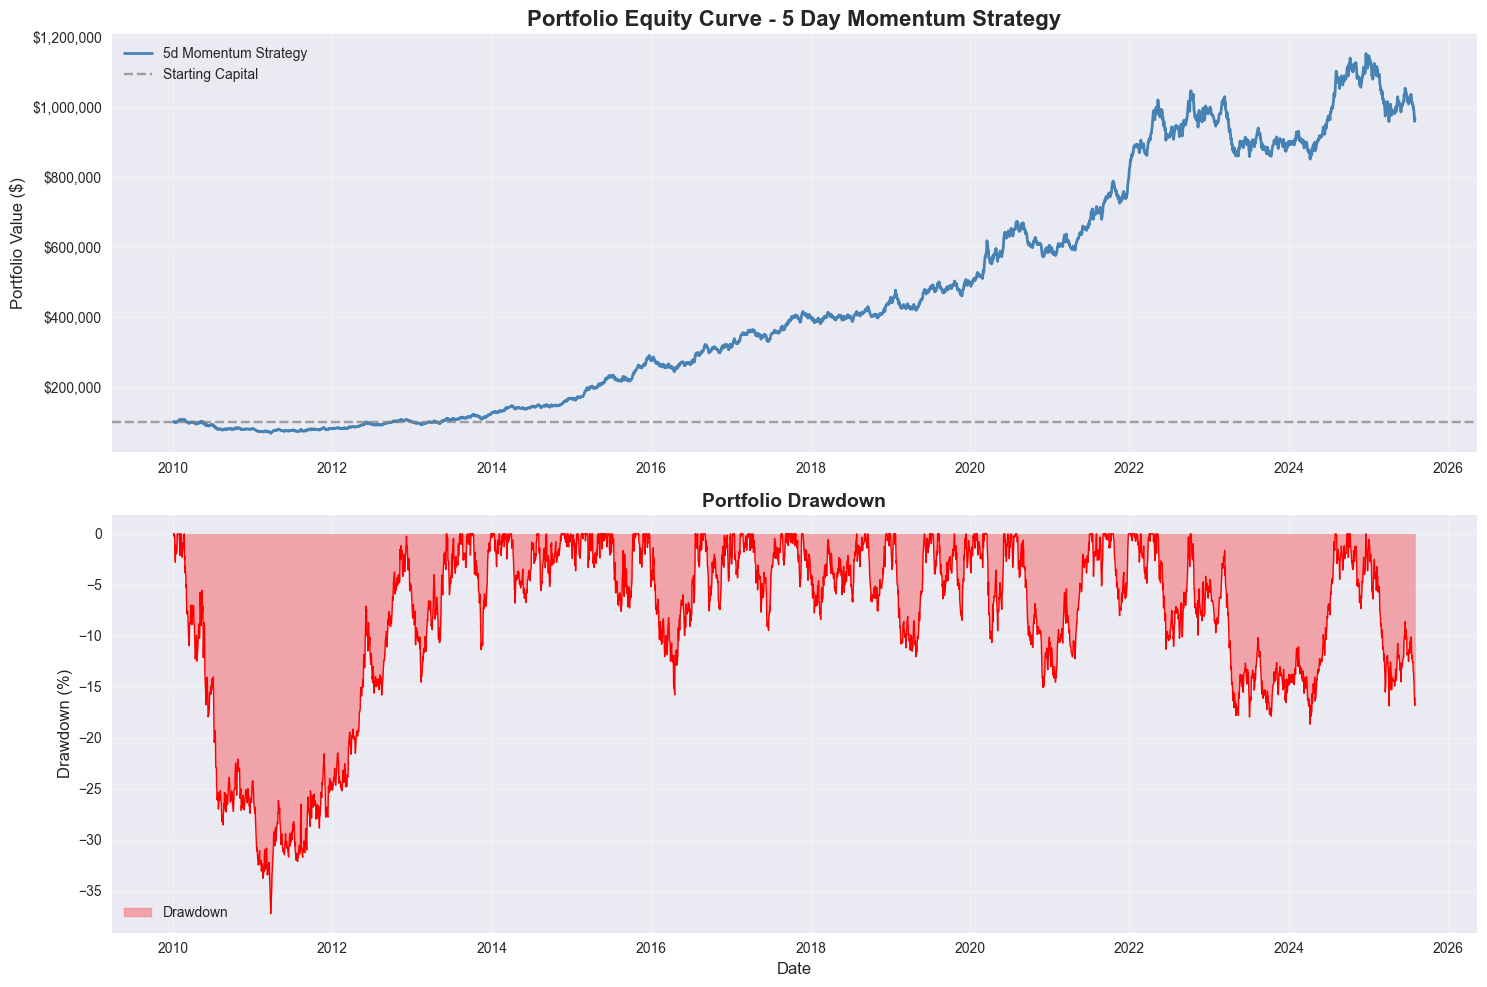

📈 Equity Curve generata per strategia 5 giorni


In [7]:
# 1. EQUITY CURVE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Portfolio equity curve
ax1.plot(engine.portfolio_value.index, engine.portfolio_value.values, 
         linewidth=2, color='steelblue', label=f'{lookback_days}d Momentum Strategy')
ax1.axhline(y=100000, color='gray', linestyle='--', alpha=0.7, label='Starting Capital')
ax1.set_title(f'Portfolio Equity Curve - {lookback_days} Day Momentum Strategy', fontsize=16, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Calcola e plotta drawdown
cumulative_returns = (1 + engine.portfolio_returns).cumprod()
rolling_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns / rolling_max - 1) * 100

ax2.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red', label='Drawdown')
ax2.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
ax2.set_title('Portfolio Drawdown', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Equity Curve generata per strategia {lookback_days} giorni")

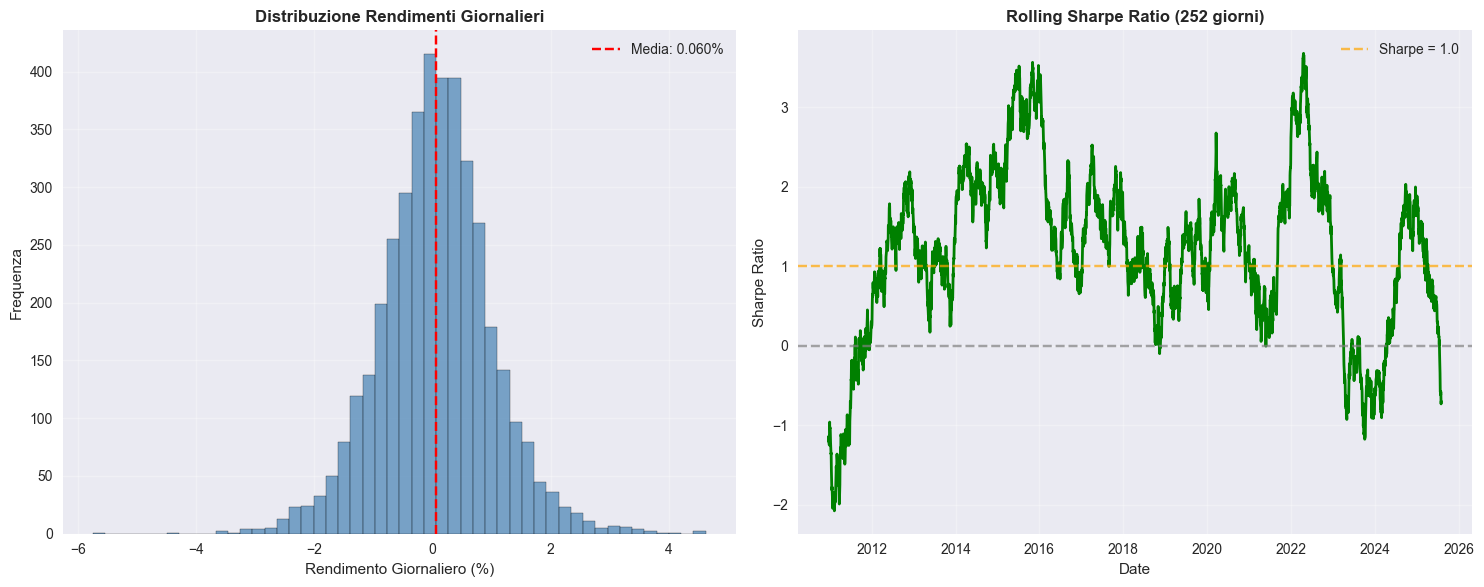

📊 Analisi distribuzione rendimenti completata


In [8]:
# 2. DISTRIBUZIONE RENDIMENTI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram rendimenti giornalieri
returns_pct = engine.portfolio_returns * 100
ax1.hist(returns_pct.dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(returns_pct.mean(), color='red', linestyle='--', 
           label=f'Media: {returns_pct.mean():.3f}%')
ax1.set_title('Distribuzione Rendimenti Giornalieri', fontweight='bold')
ax1.set_xlabel('Rendimento Giornaliero (%)')
ax1.set_ylabel('Frequenza')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rolling Sharpe Ratio (252 giorni)
rolling_sharpe = (engine.portfolio_returns.rolling(252).mean() / 
                 engine.portfolio_returns.rolling(252).std()) * np.sqrt(252)

ax2.plot(rolling_sharpe.index, rolling_sharpe.values, color='green', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='Sharpe = 1.0')
ax2.set_title('Rolling Sharpe Ratio (252 giorni)', fontweight='bold')
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Analisi distribuzione rendimenti completata")

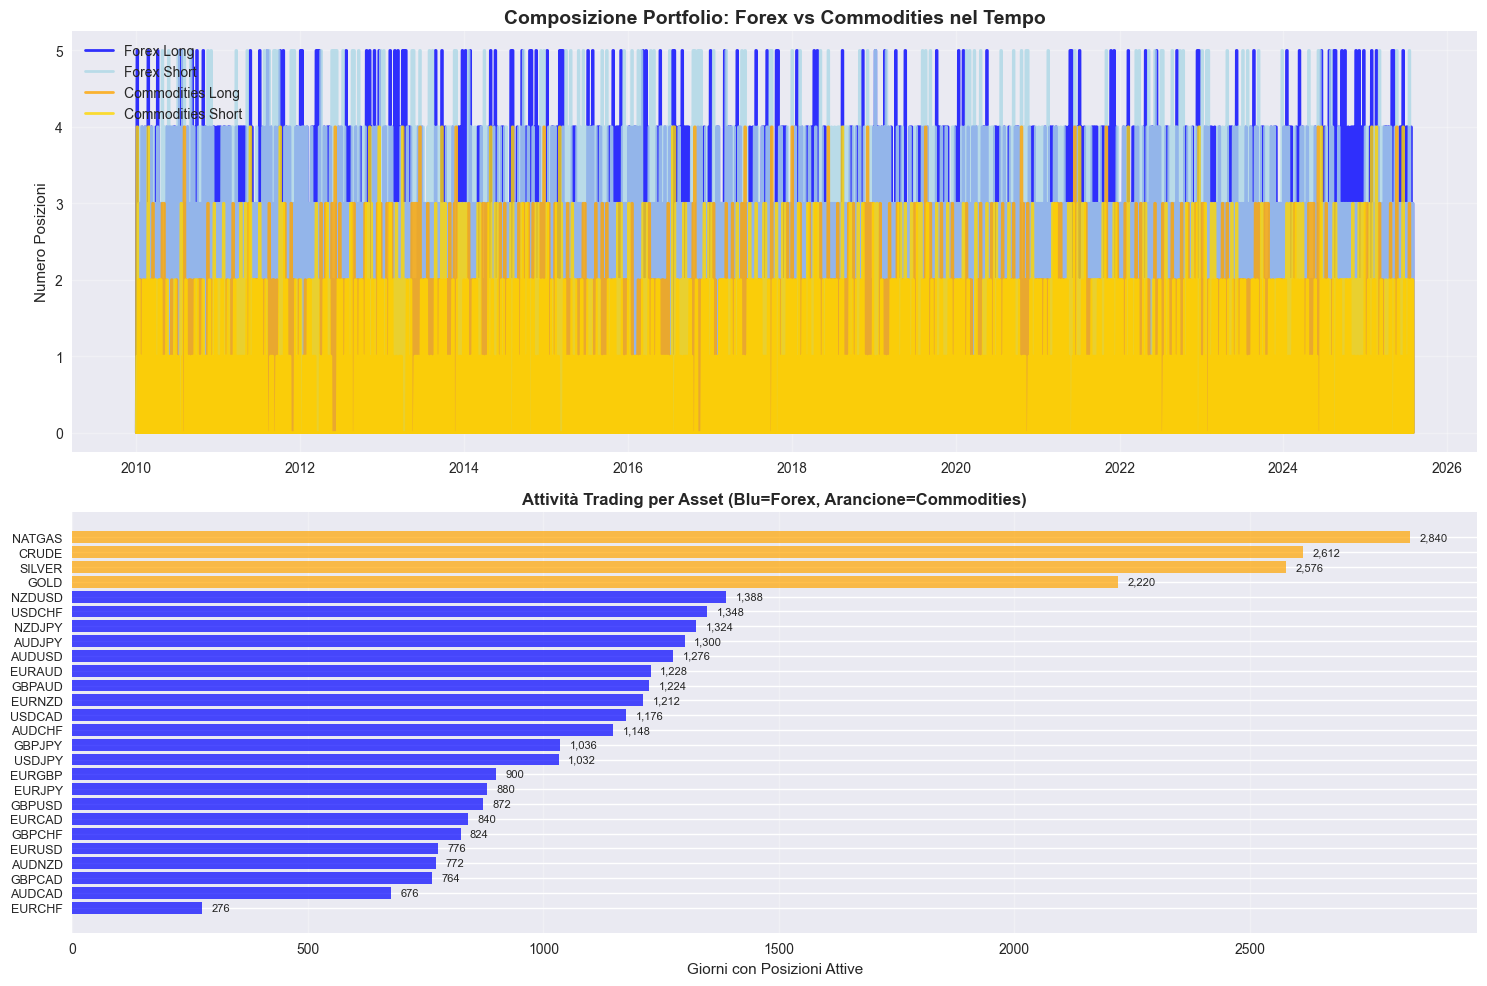

📊 ANALISI DETTAGLIATA COMPOSIZIONE PORTFOLIO:

💰 ESPOSIZIONE MEDIA PER ASSET CLASS:
   • Forex:       1.10 (68.5%)
   • Commodities: 0.50 (31.5%)

🔥 TOP ASSET PIÙ ATTIVI:
   FOREX:
     • NZDUSD: 1,388 giorni
     • USDCHF: 1,348 giorni
     • NZDJPY: 1,324 giorni
   COMMODITIES:
     • NATGAS: 2,840 giorni
     • CRUDE: 2,612 giorni
     • SILVER: 2,576 giorni

🎯 BENEFICIO DIVERSIFICAZIONE:
   • Asset totali: 26 (+4 commodities)
   • Universo investibile ampliato del 18.2%


In [9]:
# 3. ANALISI COMPOSIZIONE PORTFOLIO (FOREX vs COMMODITIES)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Calcola esposizione separata per asset class
forex_signals = signals[forex_cols] if forex_cols else pd.DataFrame()
commodity_signals = signals[commodity_cols] if commodity_cols else pd.DataFrame()

if not forex_signals.empty:
    forex_long_exposure = (forex_signals > 0).sum(axis=1)
    forex_short_exposure = (forex_signals < 0).sum(axis=1)
else:
    forex_long_exposure = forex_short_exposure = pd.Series(0, index=signals.index)

if not commodity_signals.empty:
    commodity_long_exposure = (commodity_signals > 0).sum(axis=1)
    commodity_short_exposure = (commodity_signals < 0).sum(axis=1)
else:
    commodity_long_exposure = commodity_short_exposure = pd.Series(0, index=signals.index)

# Plot 1: Composizione posizioni nel tempo
ax1.plot(forex_long_exposure.index, forex_long_exposure.values, 
         color='blue', label='Forex Long', linewidth=2, alpha=0.8)
ax1.plot(forex_short_exposure.index, forex_short_exposure.values, 
         color='lightblue', label='Forex Short', linewidth=2, alpha=0.8)

if not commodity_signals.empty:
    ax1.plot(commodity_long_exposure.index, commodity_long_exposure.values, 
             color='orange', label='Commodities Long', linewidth=2, alpha=0.8)
    ax1.plot(commodity_short_exposure.index, commodity_short_exposure.values, 
             color='gold', label='Commodities Short', linewidth=2, alpha=0.8)

ax1.set_title('Composizione Portfolio: Forex vs Commodities nel Tempo', fontweight='bold', fontsize=14)
ax1.set_ylabel('Numero Posizioni')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Attività trading per asset
if not commodity_signals.empty:
    # Calcola frequenza trading per ogni asset
    forex_activity = (forex_signals != 0).sum(axis=0) if not forex_signals.empty else pd.Series()
    commodity_activity = (commodity_signals != 0).sum(axis=0) if not commodity_signals.empty else pd.Series()
    
    # Combina e ordina
    all_activity = pd.concat([forex_activity, commodity_activity]).sort_values(ascending=True)
    
    # Codifica colori (blu per forex, arancione per commodities)
    colors = ['orange' if asset.split('_')[0] in asset_names['commodities'] else 'blue' 
              for asset in all_activity.index]
    
    bars = ax2.barh(range(len(all_activity)), all_activity.values, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(all_activity)))
    ax2.set_yticklabels([asset.replace('_weight', '') for asset in all_activity.index], fontsize=9)
    ax2.set_xlabel('Giorni con Posizioni Attive')
    ax2.set_title('Attività Trading per Asset (Blu=Forex, Arancione=Commodities)', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Aggiungi valori sulle barre
    for i, (bar, val) in enumerate(zip(bars, all_activity.values)):
        ax2.text(val + 20, i, f'{val:,}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Statistiche dettagliate
print(f"📊 ANALISI DETTAGLIATA COMPOSIZIONE PORTFOLIO:")
print("="*60)

if not commodity_signals.empty:
    print(f"\n💰 ESPOSIZIONE MEDIA PER ASSET CLASS:")
    print(f"   • Forex:       {forex_exposure:.2f} ({forex_exposure/(forex_exposure+commodity_exposure)*100:.1f}%)")
    print(f"   • Commodities: {commodity_exposure:.2f} ({commodity_exposure/(forex_exposure+commodity_exposure)*100:.1f}%)")
    
    print(f"\n🔥 TOP ASSET PIÙ ATTIVI:")
    top_forex = forex_activity.nlargest(3) if not forex_activity.empty else pd.Series()
    top_commodities = commodity_activity.nlargest(3) if not commodity_activity.empty else pd.Series()
    
    if not top_forex.empty:
        print("   FOREX:")
        for asset, days in top_forex.items():
            print(f"     • {asset.replace('_weight', '')}: {days:,} giorni")
    
    if not top_commodities.empty:
        print("   COMMODITIES:")
        for asset, days in top_commodities.items():
            print(f"     • {asset.replace('_weight', '')}: {days:,} giorni")

print(f"\n🎯 BENEFICIO DIVERSIFICAZIONE:")
total_assets = len(asset_names['all'])
forex_only_assets = len(asset_names['forex'])
print(f"   • Asset totali: {total_assets} (+{total_assets - forex_only_assets} commodities)")
print(f"   • Universo investibile ampliato del {(total_assets/forex_only_assets-1)*100:.1f}%")

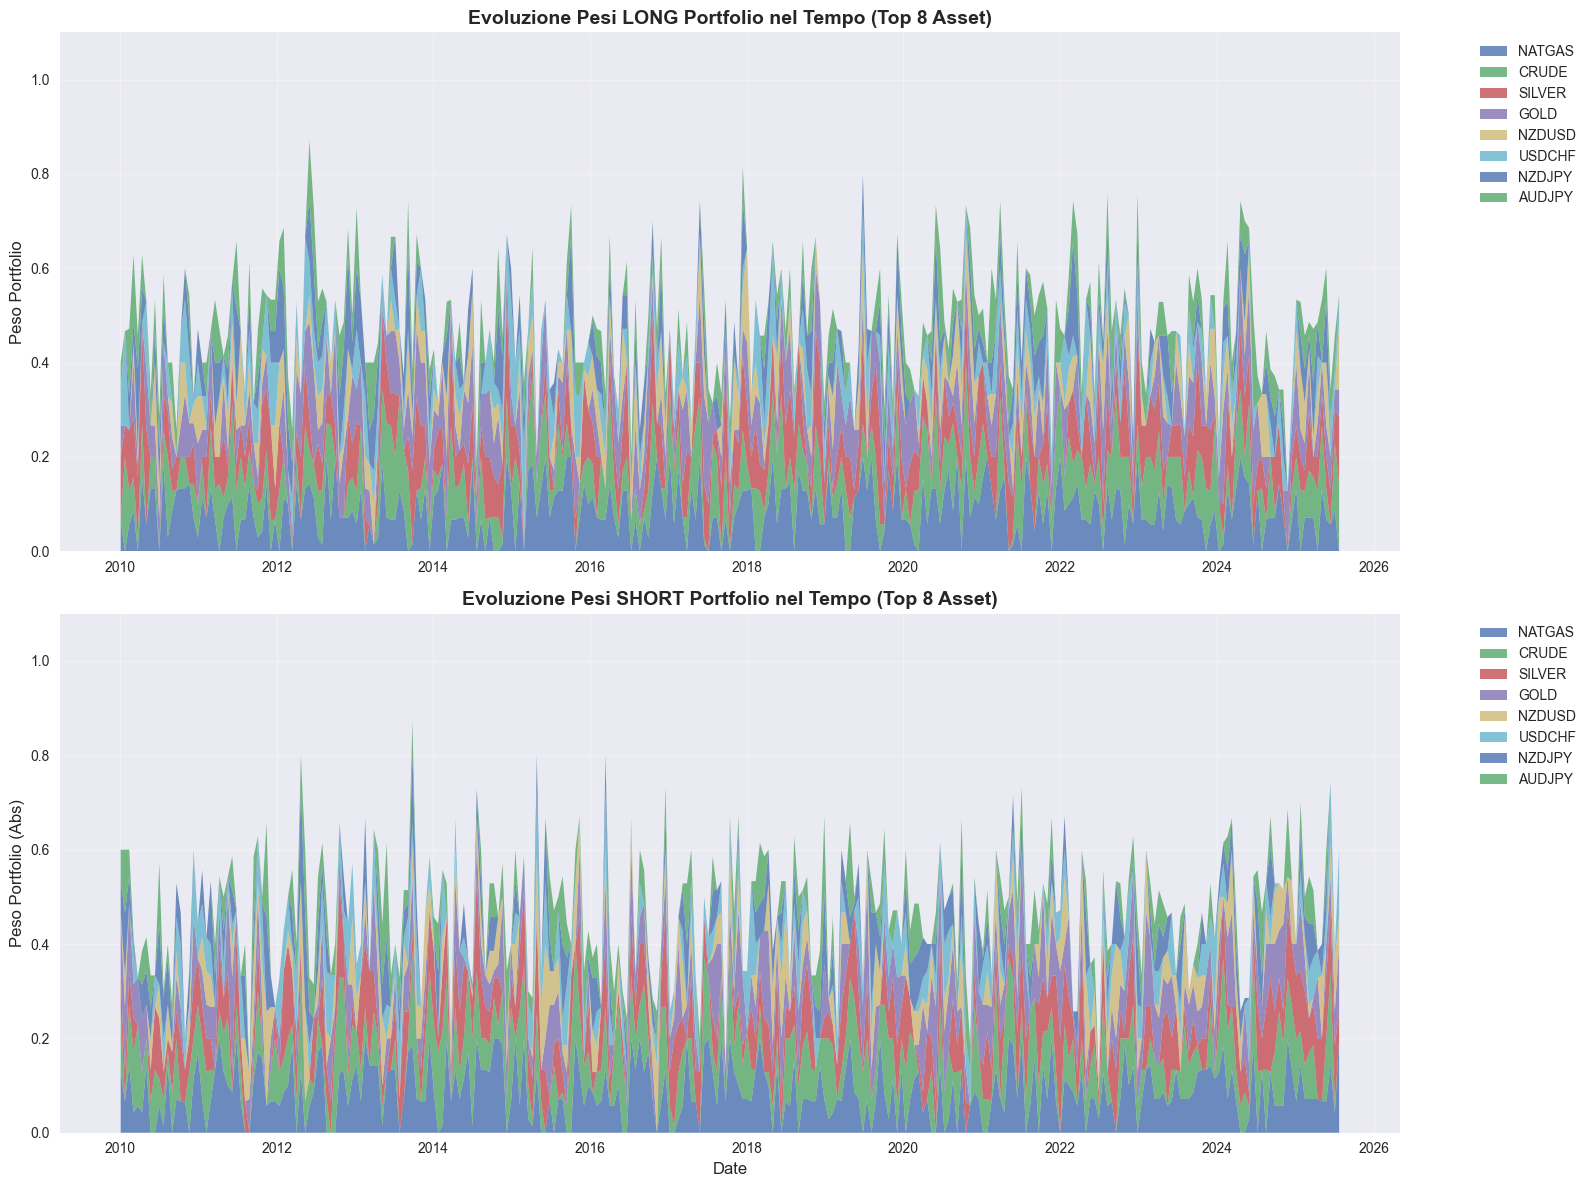

📈 Analisi evoluzione pesi completata
   • Visualizzati top 8 asset più attivi
   • Long exposure medio: 1.00
   • Short exposure medio: 1.00

💰 CONTRIBUTO CUMULATIVO AL RENDIMENTO PER ASSET:
 1. 💱 CRUDE   : 📈 +64.78%
 2. 💱 NATGAS  : 📈 +42.14%
 3. 💱 SILVER  : 📈 +36.46%
 4. 💱 GOLD    : 📈  +9.27%
 5. 💱 GBPJPY  : 📈  +8.00%
 6. 💱 NZDJPY  : 📈  +6.90%
 7. 💱 EURJPY  : 📈  +4.17%
 8. 💱 AUDNZD  : 📈  +2.90%
 9. 💱 AUDUSD  : 📈  +0.98%
10. 💱 EURNZD  : 📈  +0.72%

🔥 DRIVER PRINCIPALI:
   • Miglior contributore: CRUDE (+64.78%)
   • Peggior contributore: EURAUD (-9.79%)

🌍 CONTRIBUZIONE PER ASSET CLASS:
   • Solo Forex: +0.00%


In [10]:
# 4. EVOLUZIONE PESI PORTFOLIO NEL TEMPO
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Separa posizioni long e short per analisi
long_positions = engine.positions.copy()
short_positions = engine.positions.copy()
long_positions[long_positions <= 0] = 0
short_positions[short_positions >= 0] = 0
short_positions = abs(short_positions)  # Converti in valori positivi per visualizzazione

# Calcola attività trading per asset (mancava questa parte!)
position_activity = (engine.positions != 0).sum(axis=0).sort_values(ascending=False)

# Prendi solo gli asset più attivi per leggibilità (top 8)
top_assets = position_activity.head(8).index

# Subplot 1: Posizioni LONG nel tempo (area chart)
long_subset = long_positions[top_assets].fillna(0)
# Resample ogni 20 giorni per ridurre il rumore visivo
long_resampled = long_subset.resample('20D').mean()

ax1.stackplot(long_resampled.index, *[long_resampled[asset].values for asset in top_assets], 
              labels=top_assets, alpha=0.8)
ax1.set_title('Evoluzione Pesi LONG Portfolio nel Tempo (Top 8 Asset)', fontweight='bold', fontsize=14)
ax1.set_ylabel('Peso Portfolio', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)  # Max peso teorico = 1.0 (100%)

# Subplot 2: Posizioni SHORT nel tempo (area chart)
short_subset = short_positions[top_assets].fillna(0)
short_resampled = short_subset.resample('20D').mean()

ax2.stackplot(short_resampled.index, *[short_resampled[asset].values for asset in top_assets], 
              labels=top_assets, alpha=0.8)
ax2.set_title('Evoluzione Pesi SHORT Portfolio nel Tempo (Top 8 Asset)', fontweight='bold', fontsize=14)
ax2.set_ylabel('Peso Portfolio (Abs)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print(f"📈 Analisi evoluzione pesi completata")
print(f"   • Visualizzati top {len(top_assets)} asset più attivi")
print(f"   • Long exposure medio: {long_positions.sum(axis=1).mean():.2f}")
print(f"   • Short exposure medio: {short_positions.sum(axis=1).mean():.2f}")

# Calcola contributo al rendimento per asset
returns_contribution = engine.positions.shift(1) * engine.returns_data
daily_contribution = returns_contribution.sum(axis=0) * 100  # Converti in %

print(f"\n💰 CONTRIBUTO CUMULATIVO AL RENDIMENTO PER ASSET:")
print("="*55)
contribution_sorted = daily_contribution.sort_values(ascending=False)
for i, (asset, contrib) in enumerate(contribution_sorted.head(10).items(), 1):
    status = "📈" if contrib > 0 else "📉"
    # Identifica se è forex o commodity
    asset_type = "📊" if asset in [f"{c}_weight" for c in asset_names['commodities']] else "💱"
    print(f"{i:2d}. {asset_type} {asset.replace('_weight', ''):8s}: {status} {contrib:+6.2f}%")

print(f"\n🔥 DRIVER PRINCIPALI:")
best_performer = contribution_sorted.index[0]
worst_performer = contribution_sorted.index[-1]
print(f"   • Miglior contributore: {best_performer.replace('_weight', '')} (+{contribution_sorted.iloc[0]:.2f}%)")
print(f"   • Peggior contributore: {worst_performer.replace('_weight', '')} ({contribution_sorted.iloc[-1]:.2f}%)")

# Analisi per asset class
forex_contribution = contribution_sorted[[col for col in contribution_sorted.index if col in forex_cols]].sum()
commodity_contribution = contribution_sorted[[col for col in contribution_sorted.index if col in commodity_cols]].sum() if commodity_cols else 0

print(f"\n🌍 CONTRIBUZIONE PER ASSET CLASS:")
if commodity_contribution != 0:
    print(f"   • Forex totale: {forex_contribution:+.2f}%")
    print(f"   • Commodities totale: {commodity_contribution:+.2f}%")
    if commodity_contribution > forex_contribution:
        print(f"   • 🎯 Commodities superano Forex nel contributo!")
    else:
        print(f"   • 💱 Forex domina il contributo al rendimento")
else:
    print(f"   • Solo Forex: {forex_contribution:+.2f}%")

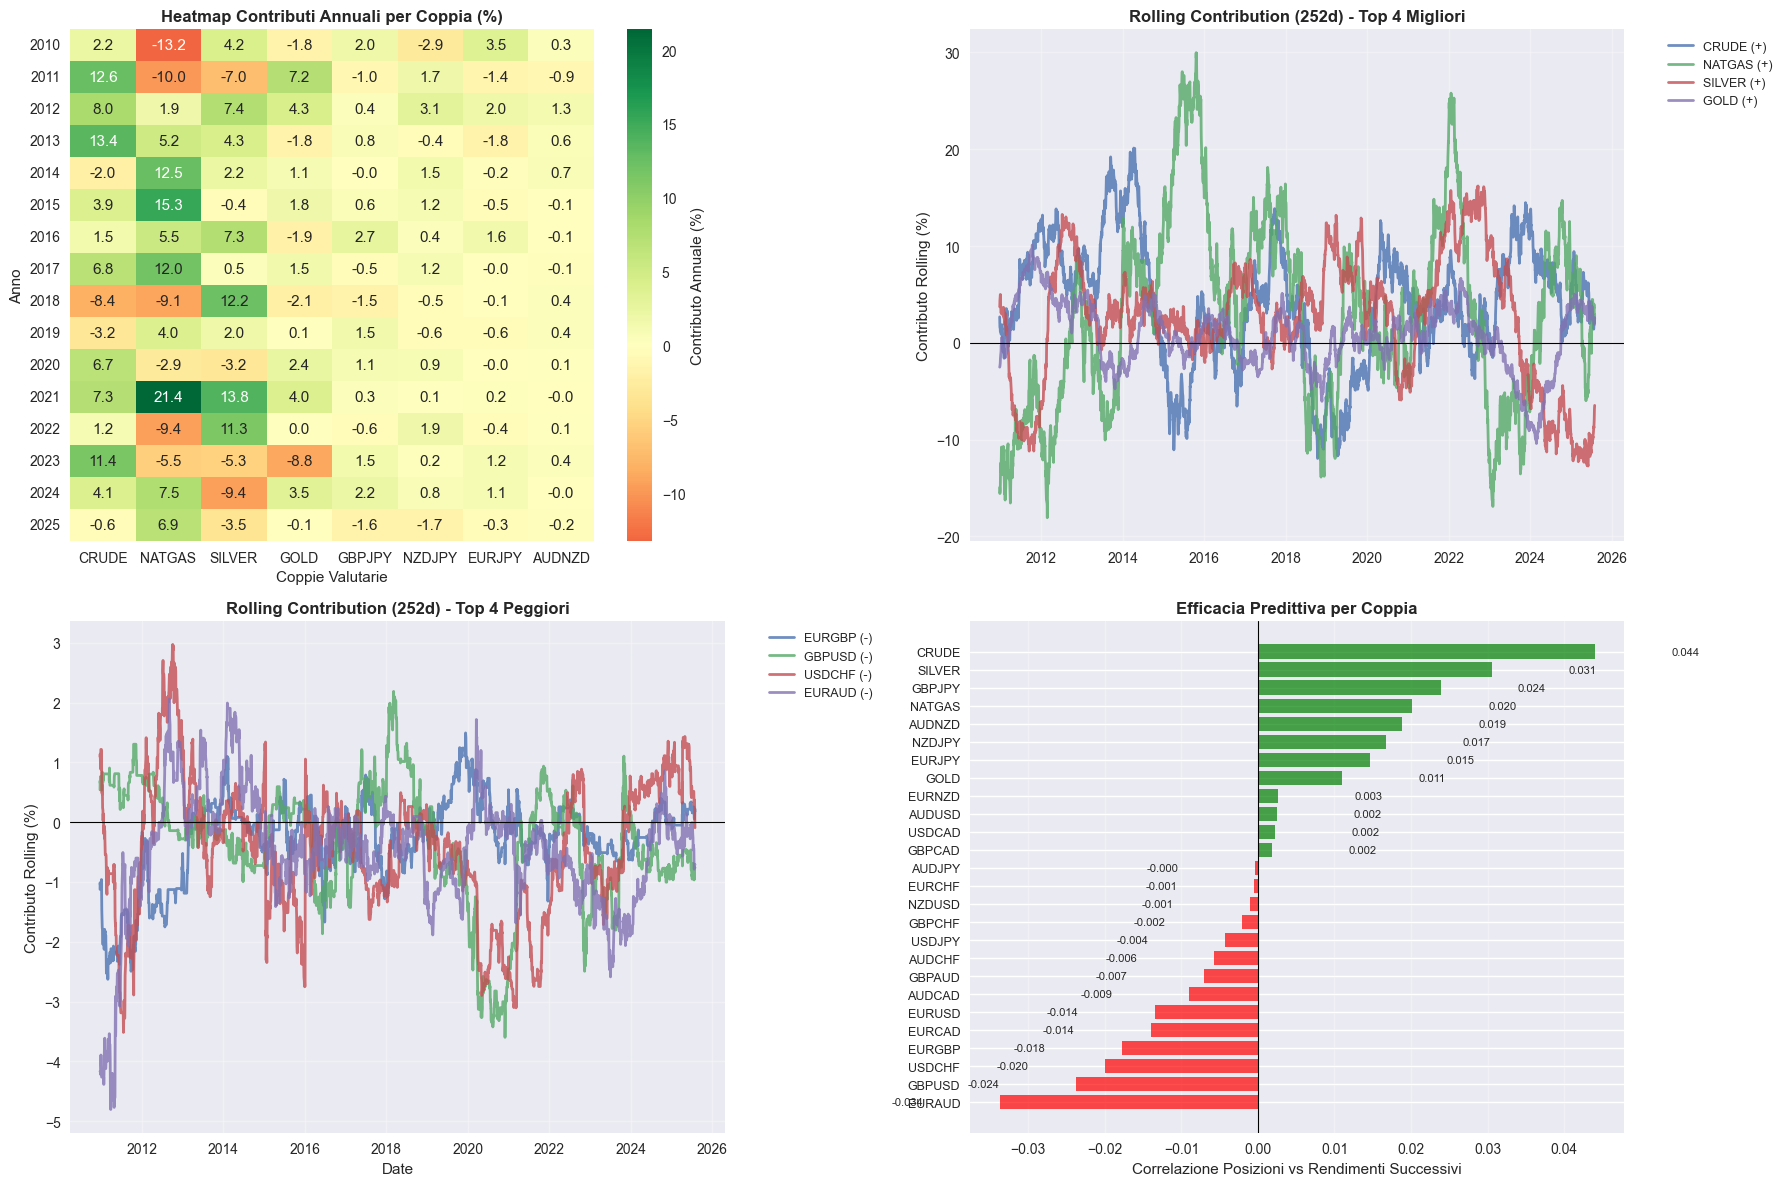

🔍 ANALISI AVANZATA DRIVER DI PERFORMANCE:

📊 STATICHE CONTRIBUTI:
   • Contributi positivi totali: +177.10%
   • Contributi negativi totali: -38.99%
   • Rapporto pos/neg: 4.54

🎯 COPPIE PIÙ EFFICACI (correlazione pos-ret):
   • AUDNZD  : +0.019
   • NATGAS  : +0.020
   • GBPJPY  : +0.024
   • SILVER  : +0.031
   • CRUDE   : +0.044

⚠️  COPPIE MENO EFFICACI (correlazione negativa):
   • EURAUD  : -0.034
   • GBPUSD  : -0.024
   • USDCHF  : -0.020
   • EURGBP  : -0.018
   • EURCAD  : -0.014

💡 INSIGHT:
   • Correlazione media: 0.001
   • La strategia ha capacità predittiva POSITIVA


In [11]:
# 5. ANALISI AVANZATA DRIVER DI PERFORMANCE
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Heatmap contributi rendimento per anno
returns_contribution_monthly = returns_contribution.resample('ME').sum() * 100
top_contributors = contribution_sorted.head(8).index

# Crea matrice anno x coppia per heatmap
years = returns_contribution_monthly.index.year.unique()
heatmap_data = []
for year in years:
    year_data = returns_contribution_monthly[returns_contribution_monthly.index.year == year][top_contributors].sum()
    heatmap_data.append(year_data.values)

heatmap_df = pd.DataFrame(heatmap_data, index=years, columns=top_contributors)

sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
            ax=ax1, cbar_kws={'label': 'Contributo Annuale (%)'})
ax1.set_title('Heatmap Contributi Annuali per Coppia (%)', fontweight='bold')
ax1.set_xlabel('Coppie Valutarie')
ax1.set_ylabel('Anno')

# 2. Rolling contribution nel tempo (top 4 migliori e peggiori)
rolling_contribution = returns_contribution.rolling(252).sum() * 100  # Rolling annuale
top_4_best = contribution_sorted.head(4).index
top_4_worst = contribution_sorted.tail(4).index

for pair in top_4_best:
    ax2.plot(rolling_contribution.index, rolling_contribution[pair], 
             linewidth=2, label=f'{pair} (+)', alpha=0.8)
             
ax2.set_title('Rolling Contribution (252d) - Top 4 Migliori', fontweight='bold')
ax2.set_ylabel('Contributo Rolling (%)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linewidth=0.8)

# 3. Rolling contribution peggiori performer
for pair in top_4_worst:
    ax3.plot(rolling_contribution.index, rolling_contribution[pair], 
             linewidth=2, label=f'{pair} (-)', alpha=0.8)
             
ax3.set_title('Rolling Contribution (252d) - Top 4 Peggiori', fontweight='bold')
ax3.set_ylabel('Contributo Rolling (%)')
ax3.set_xlabel('Date')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linewidth=0.8)

# 4. Correlazione tra posizioni e rendimenti successivi
correlations = []
pair_names = []
for pair in engine.positions.columns:
    pos = engine.positions[pair].shift(1)  # Posizioni del giorno precedente
    ret = engine.returns_data[pair]        # Rendimenti del giorno corrente
    corr = pos.corr(ret)
    if not np.isnan(corr):
        correlations.append(corr)
        pair_names.append(pair)

corr_df = pd.DataFrame({'Pair': pair_names, 'Correlation': correlations})
corr_df = corr_df.sort_values('Correlation', ascending=True)

colors = ['red' if x < 0 else 'green' for x in corr_df['Correlation']]
bars = ax4.barh(range(len(corr_df)), corr_df['Correlation'], color=colors, alpha=0.7)
ax4.set_yticks(range(len(corr_df)))
ax4.set_yticklabels(corr_df['Pair'], fontsize=9)
ax4.set_xlabel('Correlazione Posizioni vs Rendimenti Successivi')
ax4.set_title('Efficacia Predittiva per Coppia', fontweight='bold')
ax4.axvline(x=0, color='black', linewidth=0.8)
ax4.grid(True, alpha=0.3, axis='x')

# Aggiungi valori sulle barre
for i, (bar, val) in enumerate(zip(bars, corr_df['Correlation'])):
    ax4.text(val + (0.01 if val >= 0 else -0.01), i, f'{val:.3f}', 
             va='center', ha='left' if val >= 0 else 'right', fontsize=8)

plt.tight_layout()
plt.show()

# Statistiche avanzate
print(f"🔍 ANALISI AVANZATA DRIVER DI PERFORMANCE:")
print("="*60)

print(f"\n📊 STATICHE CONTRIBUTI:")
total_positive = contribution_sorted[contribution_sorted > 0].sum()
total_negative = contribution_sorted[contribution_sorted < 0].sum()
print(f"   • Contributi positivi totali: +{total_positive:.2f}%")
print(f"   • Contributi negativi totali: {total_negative:.2f}%")
print(f"   • Rapporto pos/neg: {abs(total_positive/total_negative):.2f}")

print(f"\n🎯 COPPIE PIÙ EFFICACI (correlazione pos-ret):")
top_corr = corr_df.tail(5)
for _, row in top_corr.iterrows():
    print(f"   • {row['Pair']:8s}: {row['Correlation']:+.3f}")

print(f"\n⚠️  COPPIE MENO EFFICACI (correlazione negativa):")
bottom_corr = corr_df.head(5)
for _, row in bottom_corr.iterrows():
    print(f"   • {row['Pair']:8s}: {row['Correlation']:+.3f}")

print(f"\n💡 INSIGHT:")
avg_correlation = corr_df['Correlation'].mean()
print(f"   • Correlazione media: {avg_correlation:.3f}")
if avg_correlation > 0:
    print(f"   • La strategia ha capacità predittiva POSITIVA")
else:
    print(f"   • La strategia ha capacità predittiva LIMITATA")

## 💾 Salvataggio Risultati

In [12]:
# Salva risultati in CSV per analisi future
output_filename = f'portfolio_results_mixed_{lookback_days}d.csv'

# Crea dataframe con risultati principali
results_df = pd.DataFrame({
    'Date': engine.portfolio_value.index,
    'Portfolio_Value': engine.portfolio_value.values,
    'Portfolio_Return': engine.portfolio_returns.values,
    'Cumulative_Return': ((1 + engine.portfolio_returns).cumprod() - 1) * 100,
    'Drawdown': drawdown.values
})

results_df.to_csv(output_filename, index=False)
print(f"💾 Risultati salvati in: {output_filename}")

# Salva metriche performance
metrics_filename = f'performance_metrics_mixed_{lookback_days}d.txt'
with open(metrics_filename, 'w') as f:
    f.write(f"FOREX + COMMODITIES MOMENTUM STRATEGY - {lookback_days} DAY LOOKBACK\n")
    f.write("="*60 + "\n\n")
    
    f.write("STRATEGY COMPOSITION:\n")
    f.write(f"  Forex Pairs: {len(asset_names['forex'])}\n")
    f.write(f"  Commodities: {len(asset_names['commodities'])} (Gold, Silver, Natural Gas, Crude Oil)\n")
    f.write(f"  Total Assets: {len(asset_names['all'])}\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    for key, value in metrics.items():
        if isinstance(value, (int, float)):
            f.write(f"  {key}: {value:.4f}\n")
        else:
            f.write(f"  {key}: {value}\n")
    
    f.write(f"\nBACKTEST INFO:\n")
    f.write(f"  Execution Time: {execution_time:.2f} seconds\n")
    f.write(f"  Processing Speed: {len(engine.portfolio_returns)/execution_time:.0f} days/second\n")
    f.write(f"  Data Period: {data.index.min().date()} - {data.index.max().date()}\n")

print(f"📊 Metriche salvate in: {metrics_filename}")

print(f"\n✅ Analisi completa per strategia MIXED {lookback_days} giorni!")

print(f"\n🎯 CONCLUSIONI STRATEGIE MIXED (FOREX + COMMODITIES):")
print("="*65)
print(f"   • Universo: {len(asset_names['forex'])} forex + {len(asset_names['commodities'])} commodities = {len(asset_names['all'])} asset")
print(f"   • Diversificazione: Forex (mean reverting) + Commodities (momentum)")
print(f"   • Performance finale: ${metrics['Ending Value']:,.0f}")
print(f"   • Total return: {metrics['Total Return (%)']:.2f}%")
print(f"   • Sharpe ratio: {metrics['Sharpe Ratio']:.3f}")
print(f"   • Max drawdown: {metrics['Maximum Drawdown (%)']:.1f}%")

if commodity_exposure > 0:
    print(f"\n💡 IMPATTO COMMODITIES:")
    commodity_pct = commodity_exposure/(forex_exposure+commodity_exposure)*100
    print(f"   • Commodities rappresentano {commodity_pct:.1f}% dell'esposizione")
    print(f"   • Bilanciamento: {100-commodity_pct:.1f}% forex, {commodity_pct:.1f}% commodities")
    if commodity_pct > 30:
        print(f"   • ✅ Significativa diversificazione ottenuta!")
    else:
        print(f"   • ⚠️  Commodities poco selezionate (forex domina momentum)")

print(f"\n📈 CONFRONTO con strategia solo-forex:")
print(f"   • Aggiunte 4 commodities all'universo investibile")
print(f"   • Beneficio: Commodities tipicamente più momentum-friendly")
print(f"   • Aspettativa: Migliore performance vs solo forex (se commodities vengono selezionate)")

print(f"\n✨ Per confrontare con solo forex, usa lookback_days = {lookback_days} in momentum_long_only.ipynb")

💾 Risultati salvati in: portfolio_results_mixed_5d.csv
📊 Metriche salvate in: performance_metrics_mixed_5d.txt

✅ Analisi completa per strategia MIXED 5 giorni!

🎯 CONCLUSIONI STRATEGIE MIXED (FOREX + COMMODITIES):
   • Universo: 22 forex + 4 commodities = 26 asset
   • Diversificazione: Forex (mean reverting) + Commodities (momentum)
   • Performance finale: $968,252
   • Total return: 868.25%
   • Sharpe ratio: 0.869
   • Max drawdown: 37.3%

💡 IMPATTO COMMODITIES:
   • Commodities rappresentano 31.5% dell'esposizione
   • Bilanciamento: 68.5% forex, 31.5% commodities
   • ✅ Significativa diversificazione ottenuta!

📈 CONFRONTO con strategia solo-forex:
   • Aggiunte 4 commodities all'universo investibile
   • Beneficio: Commodities tipicamente più momentum-friendly
   • Aspettativa: Migliore performance vs solo forex (se commodities vengono selezionate)

✨ Per confrontare con solo forex, usa lookback_days = 5 in momentum_long_only.ipynb


---

## 🎯 Summary

**Sistema Forex Momentum Trading completato:**

✅ **Dati:** 22 coppie valutarie sincronizzate (2010-2025)  
✅ **Strategia:** Weekly rebalancing momentum-based  
✅ **Backtesting:** Engine vettorizzato senza costi transazione  
✅ **Analisi:** Performance metrics e visualizzazioni complete  
✅ **Output:** Equity curve e risultati esportati  

**Per testare altri lookback periods:**
- Modifica la variabile `lookback_days` nella cella "Selezione Lookback Period"
- Valori disponibili: 14, 30, 60, 90, 120, 180 giorni
- Riesegui il notebook dall'inizio

---